In [ ]:
# ..... integrated - each sample and MN ..... #

In [3]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)

In [1]:
# load data
get_seurat_obj <- function(currstage1){
    
    sc1 = readRDS(paste0(currstage1, '_integrated_cca.rds'))

#     df1 = read.delim(paste0(currstage1, '_Knight-Schrijver_celltypes.csv'), sep = ',')
    df1 = read.delim(paste0(currstage1, '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    
    ids = match(rownames(sc1@meta.data), df1$barcode)
    
#     sc1$class = df1$class[ids]
#     sc1$celltype = df1$final_celltype[ids]
#     sc1$cluster = df1$cluster[ids]
    
    sc1$celltype = df1$monocle_cluster[ids]
    sc1$celltype2 = df1$shc_cluster[ids]

    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    return(sc1)
}

In [25]:
# load individual sample files
stage1 = 'stage21'
sce1 = get_seurat_obj(stage1)

# get metadata
# cols = c('stage', 'sample', 'class', 'celltype')
cols = c('stage', 'sample', 'celltype', 'celltype2')
mtd0 = sce1@meta.data[,cols]

# make SCE object
sce = SingleCellExperiment(list(counts = sce1@assays$RNA@counts),
                           colData = DataFrame(mtd0))

options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$sample)
length(hvg)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

[1] 5769

Time difference of 17.52537 secs

In [34]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$sample, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

# topdf = topHits(aurocsall, dat = sce, study_id = sce$sample, 
#                 cell_type = sce$cluster, threshold = 0.95)

# save
# save(aurocs1v1, aurocsall, topdf, 
#      file = paste0(stage1, '_', stage2, '_metacell_MN.Rdata'))

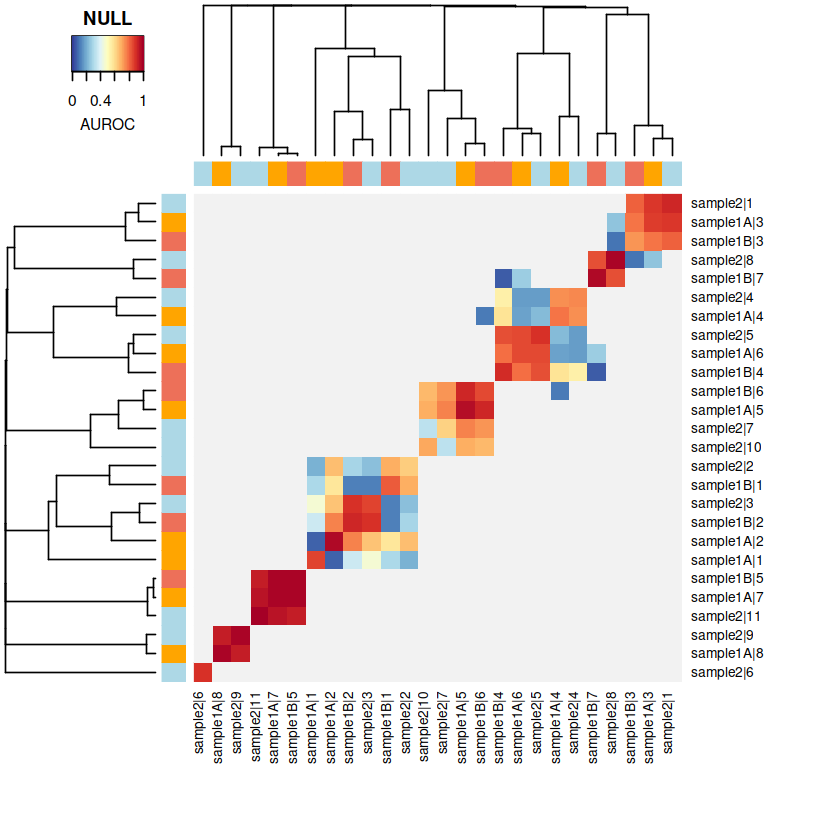

In [36]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
reg2 = sort(unique(sce$sample))
regcols2 = c('orange', '#ed7059', 'lightblue')
cols2 = regcols2[match(exps, reg2)]

# png('aabbcc.png', width = 10, height = 10, res = 300, units = 'in')
plotHeatmap(aurocs1v1, ColSideColors = cols2, RowSideColors = cols2, margins = c(10,10))
# dev.off()

In [28]:
top_all = topHits(aurocsall, dat = sce, study_id = sce$sample, 
                cell_type = sce$celltype, threshold = 0.85)
dim(top_all)
head(top_all)

top_1v1 = topHits(aurocs1v1, dat = sce, study_id = sce$sample, 
                cell_type = sce$celltype, threshold = 0.85)

[1] 15  4

Study_ID|Celltype_1 Study_ID|Celltype_2 Mean_AUROC Match_type        
1 sample1A|5          sample2|7           0.99       Reciprocal_top_hit
2 sample1A|7          sample1B|5          0.99       Reciprocal_top_hit
3 sample2|7           sample1B|6          0.99       Above_0.85        
4 sample1A|8          sample2|9           0.99       Reciprocal_top_hit
5 sample1A|7          sample2|11          0.99       Above_0.85        
6 sample1A|5          sample2|10          0.98       Above_0.85

In [29]:
# save MN scores
save(aurocsall, aurocs1v1, top_all, top_1v1, file = paste0(stage1, '_monocle_cluster_MN_scores.Rdata'))

In [43]:
# plot heatmaps #
lookup = read.delim('~/septation/chicken/knight_schrijver_class_subclass.csv', sep = ',')
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('.*\\|', '', rownames(aurocsall))
ctypes2 = lookup$class[match(ctypes, lookup$subclass)]

subs2 = c('Endocardial', 'Immature_Cardiomyocytes', 'Cardiomyocytes', 'Smooth_Muscle_Cells',  
          'Myeloid_Immune_Cells', 'Pericytes_Stromal', 'Fibroblasts',
          'Endothelial_Venous', 'Endothelial_Capillaries', 'Neuronal_Cells')
subcol2 = c('#574e3c', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#651f7e', '#358957',
            '#4d9ec3', '#84b023', '#4900e6')
reg2 = sort(unique(sce1$sample))
regcols2 = c('orange', '#ed7059', 'lightblue')

cols1 = subcol2[match(ctypes, subs2)]
cols2 = regcols2[match(exps, reg2)]

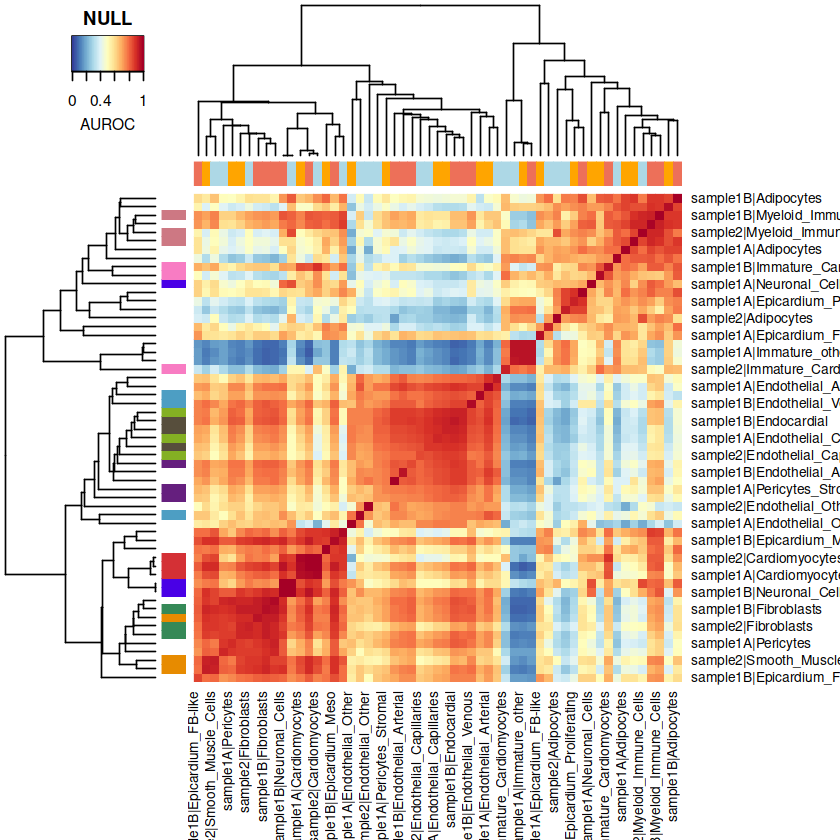

In [44]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-stage32-cls-colors.pdf', width = 10, height = 10)
plotHeatmap(aurocsall, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [47]:
table(sce$class)
table(sce$celltype)


              Adipocytes           Cardiomyocytes              Endocardial 
                      15                     1161                     3012 
    Endothelial_Arterial  Endothelial_Capillaries        Endothelial_Other 
                     132                      962                        7 
      Endothelial_Venous       Epicardium_FB-like          Epicardium_Meso 
                      70                      404                      132 
Epicardium_Proliferating              Fibroblasts  Immature_Cardiomyocytes 
                     193                     1688                      302 
          Immature_other    Lymphoid_Immune_Cells     Myeloid_Immune_Cells 
                   13252                      180                       67 
          Neuronal_Cells                Pericytes        Pericytes_Stromal 
                      18                      585                     2301 
     Smooth_Muscle_Cells 
                    1051 


                Adipocytes                    B_cells 
                        15                         28 
            Cardiomyocytes                Endocardial 
                        31                       3012 
      Endothelial_Arterial    Endothelial_Capillaries 
                       132                        962 
         Endothelial_Other         Endothelial_Venous 
                         7                         70 
        Epicardium_FB-like            Epicardium_Meso 
                       404                        132 
  Epicardium_Proliferating            Fibroblast-like 
                       193                         94 
               Fibroblasts    Immature_Cardiomyocytes 
                      1594                        302 
      Immature_Endothelium           Immature_FB-like 
                     11226                       1498 
      Immature_Neuralcrest             Immature_other 
                       506                         22 
     Lymp